<font size="5"> Capstone Project: 2018 Stackoverflow Developer Survey analysis<br> 

<font size="4">Table of Contents <br> 
 <font size="2.5">
[1 DataWrangling](#DataWrangling)<br> 
[2 Data Preprocessing](#DataPreprocessing) <br> 
[3 Data Exploration/ Statistical Analysis](#DataExploration) <br> 
[3.1 Correlation between variables](#Correlation) <br>
[3.2 T-test between populations](#T-test) <br>
[3.3 Data by Country/Continent](#DatabyCountry/Continent) <br>
[4 Data Visualization](#DataViz) <br> 
[4.1 Variables affecting Career Satisfaction](#Carsatvsother) <br> 
[5 Machine Learning (In progress)](#MachineLearning)


In [1]:
#https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey
%matplotlib inline
%autosave 30
import pandas as pd;import numpy as np;import seaborn as sns;import researchpy as rp;from scipy import stats;import matplotlib.pyplot as plt
from sklearn import preprocessing;from sklearn.preprocessing import MultiLabelBinarizer;from sklearn.preprocessing import MinMaxScaler;from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split;from sklearn.linear_model import LinearRegression;from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid;from sklearn.metrics import roc_auc_score;import parfit.parfit as pf;from sklearn import metrics
from itertools import cycle;from sklearn.linear_model import ElasticNet;from sklearn.model_selection import GridSearchCV;from sklearn.metrics import confusion_matrix;
from sklearn.metrics import mean_squared_error;from sklearn.neighbors import KNeighborsClassifier;from sklearn.metrics import r2_score
from sklearn import linear_model;from sklearn.linear_model import Lasso;from sklearn.linear_model import LogisticRegression;
from sklearn import svm;from sklearn.svm import LinearSVR;from sklearn.datasets import make_regression;from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier;from sklearn.naive_bayes import MultinomialNB;from sklearn.preprocessing import LabelEncoder;
from sklearn.preprocessing import OneHotEncoder;import sklearn.feature_selection ;import warnings;from pandas.core.common import SettingWithCopyWarning
from sklearn.ensemble import GradientBoostingRegressor; from statsmodels.stats.proportion import proportions_ztest;#from xgboost import XGBClassifier
from patsy import dmatrices;import statsmodels.api as sm;from statsmodels.stats.outliers_influence import variance_inflation_factor;
warnings.simplefilter(action="ignore")

Autosaving every 30 seconds


In [2]:
############################## FUNCTIONS TO NUMERICIZE VARIABLES #################################
def seriesify(df,strd,numd,colname):
    ziptemp = zip(strd,numd)
    dictemp = dict(ziptemp)
    return df[colname].replace(dictemp)
def dummify(df,colname,ser):
    ser = ser.rename(colname+'_n')
    df = pd.concat([df,ser],axis=1)
    df = df.drop(colname,axis=1)
    return df
def satisfaction_perc(df_c):
    df_c['Total'] = df_c[['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']].sum(axis=1)
    df_c['Satisfied']=df_c[['Extremely satisfied','Moderately satisfied','Slightly satisfied']].sum(axis=1)
    df_c['% Satisfied'] =  df_c['Satisfied']*100/df_c['Total']  
    df_c['% Extremely Satisfied'] =  df_c['Extremely satisfied']*100/df_c['Total']  
    df_c['% Moderately Satisfied'] =  df_c['Moderately satisfied']*100/df_c['Total'] 
    df_c['% Slightly Satisfied'] =  df_c['Slightly satisfied']*100/df_c['Total'] 
    df_c['% Dissatisfied'] = 100-df_c['% Satisfied']-(df_c['Neither satisfied nor dissatisfied']*100/df_c['Total'])
    return df_c

<a id='DataWrangling'></a> <font size="5"><b>Data Wrangling</b>

In [3]:
%%time
survey_questions = pd.read_csv('survey_results_schema.csv')
data = pd.read_excel('survey_results_public_filtered.xlsx')

Wall time: 38.3 s


In [160]:
print('Total responses: ' + str(data.shape[0]));print('Total features/questions: ' + str(data.shape[1]))

Total responses: 98855
Total features/questions: 40


In [161]:
pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).style.set_caption("Features and number of null values for each feature") # Num of null values in each column

,0
ConvertedSalary,51153
FrameworkWorkedWith,47235
TimeFullyProductive,46983
CommunicationTools,41885
SelfTaughtTypes,41501
Gender,34386
Age,34281
UpdateCV,33316
PlatformWorkedWith,32856
DatabaseWorkedWith,32585


<div class="span5 alert alert-success">
22,000 missing CareerSatisfaction responses and 51,153 missing ConvertedSalary responses are some of the biggest features with missing variables.    
</div> 

In [162]:
data.columns;

In [163]:
clean_df1 = data.dropna(subset=['EthicalImplications','AIFuture','YearsCoding','EthicsReport','EthicsChoice',\
        'CompanySize','HoursOutside','Exercise','CareerSatisfaction','DevType','FormalEducation', 'YearsCodingProf',
       'HopeFiveYears', 'LastNewJob', 'JobSearchStatus','CommunicationTools','TimeFullyProductive','LanguageWorkedWith','UpdateCV',
        'CommunicationTools', 'TimeFullyProductive', 'LanguageWorkedWith','LanguageDesireNextYear', 'DatabaseWorkedWith', 'PlatformWorkedWith','FrameworkWorkedWith', 'IDE', 'OperatingSystem', 'HoursComputer',
       'SkipMeals', 'Gender', 'Age'])
clean_df1.shape

(22968, 40)

In [164]:
## Drop NaN values from certain columns
clean_df2 = data.dropna(subset=['ConvertedSalary','EthicalImplications','AIFuture','YearsCoding','EthicsReport','EthicsChoice',\
        'CompanySize','HoursOutside','Exercise','CareerSatisfaction','DevType','FormalEducation', 'YearsCodingProf',
       'HopeFiveYears', 'LastNewJob', 'JobSearchStatus','CommunicationTools','TimeFullyProductive','LanguageWorkedWith','UpdateCV',
       'OperatingSystem', 'HoursComputer','SkipMeals', 'Gender', 'Age'])
clean_df2.shape

(32359, 40)

In [165]:
## Drop NaN values from certain columns
clean_df = data.dropna(subset=['ConvertedSalary','EthicalImplications','AIFuture','YearsCoding','EthicsReport','EthicsChoice',\
        'CompanySize','HoursOutside','Exercise','CareerSatisfaction','DevType','FormalEducation', 'YearsCodingProf',
       'HopeFiveYears', 'LastNewJob', 'JobSearchStatus','CommunicationTools','TimeFullyProductive','UpdateCV',
       'OperatingSystem', 'HoursComputer','SkipMeals', 'Gender', 'Age'])
clean_df.shape

(32421, 40)

In [166]:
#Dropping LanguageDesireNextYear (losing 500 datapoints),database(-1k),PlatformWorkedWith (-1k),[data.Country=='United States']

In [167]:
clean_df_ml = data.dropna(subset=['Employment','ConvertedSalary','EthicalImplications','AIFuture','YearsCoding','EthicsReport','EthicsChoice',\
        'CompanySize','HoursOutside','Exercise','CareerSatisfaction','DevType','FormalEducation', 'YearsCodingProf',
       'HopeFiveYears', 'LastNewJob', 'JobSearchStatus','CommunicationTools','TimeFullyProductive','UpdateCV',
       'OperatingSystem', 'HoursComputer','SkipMeals', 'Gender', 'Age','Country','LanguageWorkedWith','LanguageDesireNextYear','IDE']);clean_df_ml.shape

(30465, 40)

In [168]:
clean_df_ml.columns

Index(['Hobby', 'OpenSource', 'Country', 'Employment', 'UndergradMajor',
       'CompanySize', 'DevType', 'YearsCoding', 'ConvertedSalary',
       'EducationTypes', 'SelfTaughtTypes', 'AIFuture', 'EthicsChoice',
       'EthicsReport', 'EthicalImplications', 'WakeTime', 'HoursOutside',
       'Exercise', 'Student', 'FormalEducation', 'YearsCodingProf',
       'HopeFiveYears', 'LastNewJob', 'JobSearchStatus', 'UpdateCV',
       'CommunicationTools', 'TimeFullyProductive', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'DatabaseWorkedWith', 'PlatformWorkedWith',
       'FrameworkWorkedWith', 'IDE', 'OperatingSystem', 'HoursComputer',
       'SkipMeals', 'Gender', 'Age', 'JobSatisfaction', 'CareerSatisfaction'],
      dtype='object')

In [169]:
# Num of null values in each column where salary is not Null
pd.DataFrame(data[data.ConvertedSalary.isnull()==False].isnull().sum().sort_values(ascending=False)).head(10);

In [170]:
print('Number of datapoints: {:,}'.format(clean_df.shape[0]))

Number of datapoints: 32,421


In [171]:
clean_df.head(1) #columns

,Hobby,OpenSource,Country,Employment,UndergradMajor,CompanySize,DevType,YearsCoding,ConvertedSalary,EducationTypes,...,PlatformWorkedWith,FrameworkWorkedWith,IDE,OperatingSystem,HoursComputer,SkipMeals,Gender,Age,JobSatisfaction,CareerSatisfaction
1,Yes,Yes,United Kingdom,Employed full-time,"A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,70841.0,"Taught yourself a new language, framework, or ...",...,Linux,Django,IPython / Jupyter;Sublime Text;Vim,Linux-based,5 - 8 hours,Never,Male,35 - 44 years old,Moderately dissatisfied,Neither satisfied nor dissatisfied


In [172]:
countries = clean_df['Country'].value_counts();
top_countries = countries[0:10] #top 10 countries with most respondents; 
top_20_countries = countries[0:20];last_20_countries=countries[-20:];countries_100_resp = countries[0:55]#top 20 countries with most respondents;

<font size="5"><a id='DataPreprocessing'></a> <b>Data Preprocessing</b>

In [173]:
df = clean_df_ml.copy()
dfd = clean_df.copy() #dataframe for dissatisfaction
dflr = clean_df.copy() #dataframe for logreg
dflrd = clean_df.copy() #dataframe for logreg dissatisfaction

In [174]:
dflrd.groupby('FormalEducation')['Hobby'].count(); # Grouped by Formal Education (number in each categoty) 

In [175]:
#Replace AIFuture values with shorter terms
clean_df['AIFuture'].replace(["I'm excited about the possibilities more than worried about the dangers.","I'm worried about the dangers more than I'm excited about the possibilities.","I don't care about it, or I haven't thought about it."],['Excited','Worried','DontCare'],inplace=True)

In [176]:
clean_df.columns;

In [177]:
usdata_ml = clean_df[clean_df.Country=='United States']; print('Number of datapoints for the US: {:,}'.format(usdata_ml.shape[0]))

Number of datapoints for the US: 9,808


In [180]:
#Explore JobSearchStatus
df_cj =clean_df.groupby(['JobSearchStatus', 'CareerSatisfaction'])['JobSearchStatus'].count().unstack('CareerSatisfaction').fillna(0);
df_cj = satisfaction_perc(df_cj)
df_cj_sat = df_cj.sort_values(by='% Satisfied',ascending=False).head(15)
#fig =df_cj_sat[['JobSearchStatus','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
#df_cj.plot(kind='bar')

In [23]:
#NUMERICIZE VARIABLES
#Numericize JobSearchStatus
if 'JobSearchStatus' in df.columns:
    jss_str=df['JobSearchStatus'].unique()
    jss_num = [0,-1,1] 
    jss_ser = seriesify(df,jss_str,jss_num,'JobSearchStatus')
    df=dummify(df,'JobSearchStatus',jss_ser)
#Numericize lastnewjob
if 'LastNewJob' in df.columns:
    lsn_str=df['LastNewJob'].unique()
    lsn_num = [.5,5,1.5,3,0] 
    lsn_ser = seriesify(df,lsn_str,lsn_num,'LastNewJob')
    df=dummify(df,'LastNewJob',lsn_ser)
#Numericize CompanySize
if 'CompanySize' in df.columns:
    comp_str=df['CompanySize'].unique()
    comp_num = [10000,15,300,1250,60,750,7500,5]
    comp_ser = seriesify(df,comp_str,comp_num,'CompanySize')
    df=dummify(df,'CompanySize',comp_ser)
#Convert Years of Coding to numeric variable
if 'YearsCoding' in df.columns:
    years = df['YearsCoding'].unique()
    yrs_num =[30,7,10,16,13,4,1,19,25,22,28]
    yrs_cod_ser = seriesify(df,years,yrs_num,'YearsCoding')
    df=dummify(df,'YearsCoding',yrs_cod_ser)
#Convert Years of Coding Professionally to numeric variable
if 'YearsCodingProf' in df.columns:
    years = df['YearsCodingProf'].unique()
    yrs_num =[30,7,10,16,13,4,1,19,25,22,284,19,13,1,22,25,7,10,16,28,30]
    yrs_cod_ser = seriesify(df,years,yrs_num,'YearsCodingProf')
    df=dummify(df,'YearsCodingProf',yrs_cod_ser)
#Numericize HoursOutside
if 'HoursOutside' in df.columns:
    hrsout_str = df['HoursOutside'].unique()
    hrsout_num = [.75,1.5,.25,3.5,4.5]
    hrsout_ser = seriesify(df,hrsout_str,hrsout_num,'HoursOutside')
    df=dummify(df,'HoursOutside',hrsout_ser)
#Numericize Exercise
if 'Exercise' in df.columns:
    ex_str=df['Exercise'].unique()
    ex_num = [6,3.5,1.5,0]
    ex_ser = seriesify(df,ex_str,ex_num,'Exercise')
    df=dummify(df,'Exercise',ex_ser)
#Numericize AIFuture
if 'AIFuture' in df.columns:
    aifuturestr=df['AIFuture'].unique()
    aifuturenum = [1,-1,0]
    ai_ser = seriesify(df,aifuturestr,aifuturenum,'AIFuture')
    df=dummify(df,'AIFuture',ai_ser)
#Numericize waketime
if 'WakeTime' in df.columns:
    wtstr=df['WakeTime'].unique()
    wtnum = [530,630,430,730,930,0,830,1030,1130,1230,0,-1]
    wt_ser = seriesify(df,wtstr,wtnum,'WakeTime')
    df=dummify(df,'WakeTime',wt_ser)
#Numericize TimeFullyProductive
if 'TimeFullyProductive' in df.columns:
    tfpstr=df['TimeFullyProductive'].unique()
    tfpnum = [7.5,4.5,.5,2,10.5,13]
    tfp_ser = seriesify(df,tfpstr,tfpnum,'TimeFullyProductive')
    df=dummify(df,'TimeFullyProductive',tfp_ser)
#Numericize HoursComputer
if 'HoursComputer' in df.columns:
    hcstr=df['HoursComputer'].unique()
    hcnum = [13,10.5,6.5,2.5,.5]
    hc_ser = seriesify(df,hcstr,hcnum,'HoursComputer')
    df=dummify(df,'HoursComputer',hc_ser)
#Replace employed full time/part time with FT/PT
df['Employment'].replace(['Employed full-time','Employed part-time'],['FT','PT'],inplace=True) 
df['Employment'].replace(['Employed full-time','Employed part-time'],['FT','PT'],inplace=True) 

In [24]:
#DUMMIFY VARIABLES
#Dummify Hobby columns
if 'Hobby' in df.columns:
    df = pd.get_dummies(data=df, columns=['Hobby'])
    df = df.drop('Hobby_No',axis=1)
#Dummify OpenSource
if 'OpenSource' in df.columns:
    df = pd.get_dummies(data=df, columns=['OpenSource'])
    df = df.drop('OpenSource_No',axis=1)
#Dummify EthicalImplications
if 'EthicalImplications' in df.columns:
    ethimpstr=df['EthicalImplications'].unique()
    ethimpnum=[3,2,1]
    ethimp_ser = seriesify(df,ethimpstr,ethimpnum,'EthicalImplications')
    df=dummify(df,'EthicalImplications',ethimp_ser)
#Dummify EthicsReport
if 'EthicsReport' in df.columns:
    ethrepstr=df['EthicsReport'].unique()
    ethrepnum=[0,1,2,-1]
    ethrep_ser = seriesify(df,ethrepstr,ethrepnum,'EthicsReport')
    df=dummify(df,'EthicsReport',ethrep_ser)

In [25]:
#Dummify UpdateCV
mlb = MultiLabelBinarizer()
if 'UpdateCV' in df.columns:
    cv_types = clean_df['UpdateCV'].unique()
    UpdateCVlist = df['UpdateCV'].str.split(';')
    UpdateCVlist.rename('NewUpdateCV',inplace=True)
    df_cv_type = pd.concat([df,UpdateCVlist],axis=1)
    df_cv_type = df_cv_type.drop('UpdateCV',axis=1)
    cv_type_num=pd.DataFrame(mlb.fit_transform(df_cv_type['NewUpdateCV']),columns=mlb.classes_, index=df_cv_type.index)#.head()
    df = pd.concat([df,cv_type_num],axis=1);df['UpdateCV'].replace(['I saw an employerâ€™s advertisement'],['I saw an employers advertisement'],inplace=True)    
if 'UpdateCV' in df.columns:   #concatenate UpdateCV dummified to df
    df = df.drop('UpdateCV',axis=1);df = df.drop('I received negative feedback on my job performance',axis=1)   

In [26]:
#Dummify DevType
mlb = MultiLabelBinarizer()
if 'DevType' in df.columns:
    dev_types = clean_df['DevType'].unique()
    devtypelist = df['DevType'].str.split(';')
    devtypelist.rename('NewDevType',inplace=True)
    df_dev_type = pd.concat([df,devtypelist],axis=1)
    df_dev_type = df_dev_type.drop('DevType',axis=1)
    dev_type_num=pd.DataFrame(mlb.fit_transform(df_dev_type['NewDevType']),columns=mlb.classes_, index=df_dev_type.index)#.head()
    df = pd.concat([df,dev_type_num],axis=1)
if 'DevType' in df.columns:  #concatenate DevType dummified to df
    df = df.drop('DevType',axis=1)

In [27]:
#Dummify LanguageWorkedWith
mlb = MultiLabelBinarizer()
if 'LanguageWorkedWith' in df.columns:
    tfp_types = clean_df['LanguageWorkedWith'].unique()
    LanguageWorkedWithlist = df['LanguageWorkedWith'].str.split(';')
    LanguageWorkedWithlist.rename('NewLanguageWorkedWith',inplace=True)
    df_tfp_type = pd.concat([df,LanguageWorkedWithlist],axis=1)
    df_tfp_type = df_tfp_type.drop('LanguageWorkedWith',axis=1)
    tfp_type_num=pd.DataFrame(mlb.fit_transform(df_tfp_type['NewLanguageWorkedWith']),columns=mlb.classes_, index=df_tfp_type.index)#.head()
if 'LanguageWorkedWith' in df.columns:   #concatenate LanguageWorkedWith dummified to df
    df = df.drop('LanguageWorkedWith',axis=1)
    df = pd.concat([df,tfp_type_num],axis=1)

In [28]:
#dummify formaleducation
if 'FormalEducation' in df.columns:
    # Get one hot encoding of columns FormalEducation
    one_hot = pd.get_dummies(df['FormalEducation'])
    # Drop column FormalEducation as it is now encoded
    df = df.drop(['FormalEducation'],axis = 1);
    # Join the encoded df
    df = df.join(one_hot)
    df = df.drop(['I never completed any formal education'],axis = 1)

In [29]:
#dummify HopeFiveYears
if 'HopeFiveYears' in df.columns:
    # Get one hot encoding of columns FormalEducation
    one_hot = pd.get_dummies(df['HopeFiveYears'])
    # Drop column FormalEducation as it is now encoded
    df = df.drop(['HopeFiveYears'],axis = 1);
    # Join the encoded df
    df = df.join(one_hot);df = df.drop(["Retirement"],axis = 1)

In [30]:
#dummify UpdateCV
if 'UpdateCV' in df.columns:
    # Get one hot encoding of columns FormalEducation
    one_hot = pd.get_dummies(df['UpdateCV'])
    # Drop column FormalEducation as it is now encoded
    df = df.drop(['UpdateCV'],axis = 1);
    # Join the encoded df
    df = df.join(one_hot)
#df = df.drop(["I received negative feedback on my job performance"],axis = 1)

In [31]:
#dummify Gender
if 'Gender' in df.columns:
    df = df[(df.Gender=='Male') | (df.Gender=='Female')]
    # Get one hot encoding of columns Gender
    one_hot = pd.get_dummies(df['Gender'])
    # Drop column Gender as it is now encoded
    df = df.drop(['Gender'],axis = 1);#df = df.drop(['Female'],axis = 1)
    # Join the encoded df
    df = df.join(one_hot)

In [32]:
if 'Female' in df.columns:
    df = df.drop(['Female'],axis = 1);

In [33]:
#Numericize CareerSatisfaction
if 'CareerSatisfaction' in df.columns:
    cs_str=df['CareerSatisfaction'].unique()
    cs_num = [3,0,-1,2,1,-2,-3] 
    cs_ser = seriesify(df,cs_str,cs_num,'CareerSatisfaction')
    df=dummify(df,'CareerSatisfaction',cs_ser)

In [182]:
#Machine learning data (only US)****
usdata_ml = df[df.Country == 'United States']
print('Number of ML datapoints for the US: {:,}'.format(usdata_ml.shape[0]))

Number of ML datapoints for the US: 9,159


In [35]:
#Add continents to the DF
continents =pd.read_csv('Countries-Continents.csv')
continents['Country'].replace(['Burma (Myanmar)','Iran','Venezuela',
                               'Congo, Democratic Republic of','Congo','Ivory Coast','US','Vietnam','Korea, South','Macedonia',
                              'Tanzania','Syria','Moldova'],
                              ['Myanmar','Iran','Venezuela, Bolivarian Republic of...',
                               'Democratic Republic of the Congo','Congo, Republic of the...',"CÃ´te d'Ivoire",'United States',
                               'Viet Nam','South Korea','The former Yugoslav Republic of Macedonia',
                              'United Republic of Tanzania','Syrian Arab Republic','Republic of Moldova'],inplace=True) 
added = pd.DataFrame({'Continent':['Asia','Asia','Asia','Europe'],'Country':['Hong Kong (S.A.R.)','Taiwan','Republic of Korea','Czech Republic']})
continents = continents.append(added,ignore_index = True);

In [36]:
%%time
african = continents[continents.Continent =='Africa']#.loc[:,'Country']
asian = continents[continents.Continent =='Asia']
NAmerican = continents[continents.Continent =='North America']
SAmerican = continents[continents.Continent =='South America']
oceania = continents[continents.Continent =='Oceania']
european = continents[continents.Continent =='Europe']
countries=(pd.DataFrame(countries))
def get_continent(d):
    continent = []
    for row in d:
        if row in asian.Country.unique():
            continent.append('Asia') 
        elif row in NAmerican.Country.unique():
            continent.append('North America') 
        elif row in (SAmerican.Country).unique():
            continent.append('Sount America') 
        elif row in (oceania.Country.unique()):
            continent.append('Oceania') 
        elif row in (european.Country.unique()):
            continent.append('Europe') 
        elif row in (african.Country.unique()):  
            continent.append('Africa')
        else:
            continent.append('Other')
    return continent

continent = get_continent(df['Country'])
df['Continent'] = continent

Wall time: 13.9 s


<a id='DataExploration'></a> <font size="5"><b>Data Exploration/Statistical Analysis</b>

<a id='Correlation'></a> <font size="4"><b>Correlation</b>

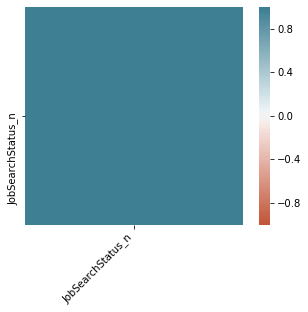

In [37]:
corr = df.iloc[:,9:19].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [38]:
df.iloc[:,8:19].corr();

<div class="span5 alert alert-success">
None of the variables seem to be correlated strongly. The only 2 variables which are at least slightly correlated (0.26) are "Open source" and "Hobby". This makes sense because people who program as a hobby are also more likely to contribute to open source projects as a part of that hobby.
 </div> 

<a id='T-test'></a> <font size="4"><b>T-test</b> <br>
<font size="3">T-test to see if populations who filled out all of the survey vs who left some fields blank are different. 

In [39]:
df_empty_cs = data[(data.ConvertedSalary.isnull()) & (data.CareerSatisfaction.isnull()==False)]; #dataframe with empty salary
df_not_empty_cs =  data[(data.ConvertedSalary.isnull() == False) & (data.CareerSatisfaction.isnull()==False)];#dataframe with filled salary

In [40]:
df_not_empty_cs.shape;

In [41]:
df_empty_cs.shape;

In [42]:
df_not_empty_cs.shape;

In [43]:
data.dropna().shape;

In [44]:
data_ttest = data.copy()
data_ttest.dropna(subset=['CareerSatisfaction'],inplace=True)
data_ttest.CareerSatisfaction.unique()

array(['Extremely satisfied', 'Neither satisfied nor dissatisfied',
       'Moderately satisfied', 'Slightly dissatisfied',
       'Slightly satisfied', 'Moderately dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [45]:
if 'CareerSatisfaction' in df_empty_cs.columns:
    cs_str=df_empty_cs['CareerSatisfaction'].unique()
    cs_num = [3,2,-1,-2,-3,0,1]
    cs_ser = seriesify(df_empty_cs,cs_str,cs_num,'CareerSatisfaction')
    df_empty_cs=dummify(df_empty_cs,'CareerSatisfaction',cs_ser)
if 'CareerSatisfaction' in df_not_empty_cs.columns:
    cs_str=df_not_empty_cs['CareerSatisfaction'].unique()
    cs_num = [0,2,1,-2,-1,3,-3] 
    cs_ser = seriesify(df_not_empty_cs,cs_str,cs_num,'CareerSatisfaction')
    df_not_empty_cs=dummify(df_not_empty_cs,'CareerSatisfaction',cs_ser)
if 'CareerSatisfaction' in data_ttest.columns:
    cs_str=data_ttest['CareerSatisfaction'].unique()
    cs_num = [3,0,2,-1,1,-2,-3] 
    cs_ser = seriesify(data_ttest,cs_str,cs_num,'CareerSatisfaction')
    data_ttest=dummify(data_ttest,'CareerSatisfaction',cs_ser)

Career Sat. on a scale from -3 to 3.

In [46]:
print('Mean Career Sat. of people with empty Salary: {:0.2f} '.format(df_empty_cs.CareerSatisfaction_n.mean())) 

Mean Career Sat. of people with empty Salary: 1.00 


In [47]:
print('Mean Career Sat. of people with filled Salary: {:0.2f} '.format(df_not_empty_cs.CareerSatisfaction_n.mean()))

Mean Career Sat. of people with filled Salary: 1.23 


In [48]:
print('Mean Career Sat. of people with multiple empty responses: {:0.2f} '.format(df.CareerSatisfaction_n.mean()))

Mean Career Sat. of people with multiple empty responses: 0.15 


In [49]:
print('Mean Career Sat. of people with all filled responses: {:0.2f} '.format(data_ttest.CareerSatisfaction_n.mean()))

Mean Career Sat. of people with all filled responses: 1.14 


In [50]:
np.std(df_empty_cs.CareerSatisfaction_n)

1.6814715696253375

In [51]:
np.std(df_not_empty_cs.CareerSatisfaction_n)

1.6051041035377622

In [52]:
np.std(data_ttest.CareerSatisfaction_n)

1.6388906979881948

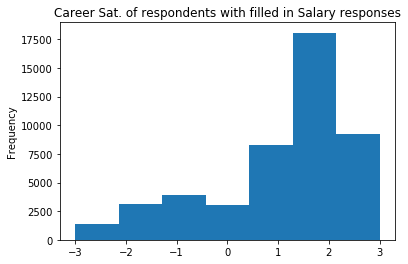

In [53]:
df_not_empty_cs.CareerSatisfaction_n.plot(kind='hist',bins=7);
plt.title('Career Sat. of respondents with filled in Salary responses');

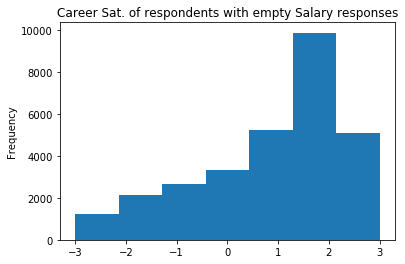

In [54]:
df_empty_cs.CareerSatisfaction_n.plot(kind='hist',bins=7);
plt.title('Career Sat. of respondents with empty Salary responses');

In [55]:
print('Stats for population with filled vs empty salary response: ')
print(stats.ttest_ind(df_empty_cs.CareerSatisfaction_n, df_not_empty_cs.CareerSatisfaction_n))

Stats for population with filled vs empty salary response: 
Ttest_indResult(statistic=-19.060104640254124, pvalue=8.345891344835878e-81)


In [56]:
print('Stats for population with everything filled vs multiple unfilled responses: ')
print(stats.ttest_ind(df.CareerSatisfaction_n, data_ttest.CareerSatisfaction_n)) 

Stats for population with everything filled vs multiple unfilled responses: 
Ttest_indResult(statistic=-93.90510944591647, pvalue=0.0)


<div class="span5 alert alert-success">
Using the T-Test, we can say that among the populations, ones who didn't reply to the salary or other questions and the ones who did, are different. The ones who answer more questions tend to be more satisfied with their career on average. </div>

<a id='DatabyCountry/Continent'></a> <font size="3"><b>Data by Country/Continent</b> <br>
<font size="2">

In [57]:
data.shape;

In [58]:
#Number of respondents from each country
counts = clean_df.Country.value_counts().reset_index(name='NumResponses') #Number of responses by country
continent_c= get_continent(counts.iloc[:,0]);
counts['Continent'] = continent_c
print('Total responses from 10 most respresented countries: '+ str(counts.iloc[:10,1:2].sum()[0]))

Total responses from 10 most respresented countries: 22486


<div class="span5 alert alert-success">
    Two thirds of the responses come from the 10 most represented countries</div>

In [183]:
pd.DataFrame(counts.groupby('Continent')['NumResponses'].sum().sort_values(ascending=False)).style.set_caption("Number of responses by Continent")

,NumResponses
Continent,
Europe,12680
North America,11521
Asia,5206
Sount America,1237
Oceania,1065
Africa,541
Other,171


In [60]:
counts.columns = ['Country', 'NumResponses', 'Continent'];
counts.index = range(1,len(counts)+1);
counts.head(10);counts.head(10).style.set_caption("10 most represented countries")

,Country,NumResponses,Continent
1,United States,9808,North America
2,United Kingdom,2694,Europe
3,India,2392,Asia
4,Germany,2213,Europe
5,Canada,1385,North America
6,France,945,Europe
7,Australia,841,Oceania
8,Russian Federation,755,Asia
9,Brazil,748,Sount America
10,Spain,705,Europe


In [61]:
#Num countries with at least 100 respondents
print('Number of countries with at least 100 responses: '+str(counts[counts.NumResponses>=100].shape[0]))

Number of countries with at least 100 responses: 40


In [62]:
counts_perc = pd.DataFrame(counts.groupby('Continent').count()['NumResponses']);counts_perc['%']= counts_perc['NumResponses']*100/counts_perc['NumResponses'].sum()
counts_perc;counts_perc.style.set_caption("% of countries by continent")

,NumResponses,%
Continent,,
Africa,30,20.8333
Asia,41,28.4722
Europe,44,30.5556
North America,13,9.02778
Oceania,3,2.08333
Other,2,1.38889
Sount America,11,7.63889


In [63]:
count100 = counts[(counts.NumResponses>=100)]#Num of countries with more than 100 respondents
count100_perc = pd.DataFrame(count100.groupby('Continent').count()['NumResponses'])
count100_perc['%']= count100_perc['NumResponses']*100/count100_perc['NumResponses'].sum() #% of countries (with at least 100 respondents) by continent
count100_perc.style.set_caption("% of countries (with at least 100 respondents) by continent")#***fix

,NumResponses,%
Continent,,
Africa,1,2.5
Asia,8,20
Europe,22,55
North America,3,7.5
Oceania,2,5
Other,1,2.5
Sount America,3,7.5


<div class="span5 alert alert-success">
After comparing the 2 tables above, we can see that Asian, African and poorer North American countries are underrespresented in the data. </div>

In [64]:
salaries_median = clean_df.groupby('Country')['ConvertedSalary'].median() #Median salary by country. # for specific: [clean_df['Country'].isin(last_20_countries.index)]
salaries_mean = pd.DataFrame(clean_df.groupby('Country')['ConvertedSalary'].mean()) #Mean of salaries by country
salaries_diff = salaries_median - salaries_mean;salaries_mean = pd.DataFrame(salaries_mean)
salaries_median = pd.DataFrame(salaries_median.sort_values(ascending=False));
if 'Continent' in df.columns:
    df.drop(columns=['Continent'],inplace=True);
salaries_median.head(10).style.set_caption("Countries with highest salary")

,ConvertedSalary
Country,
Liechtenstein,426042
Botswana,140000
Sierra Leone,120000
United States,100000
Switzerland,98534.5
Israel,94788
Bahamas,88500
Norway,85185
Denmark,82836


<div class="span5 alert alert-success">
Checking the countries with the highest salary, we can see that there are definitely a few countries with poor or non-existing data. </div>

In [65]:
#Median salary in countries with at lease 100  respondents
pd.DataFrame(clean_df[clean_df['Country'].isin(top_countries.index)].groupby('Country')['ConvertedSalary'].median().sort_values(ascending=False))

,ConvertedSalary
Country,
United States,100000.0
Australia,79973.0
Canada,64417.0
Germany,63642.0
United Kingdom,62507.0
France,50179.0
Spain,39164.0
Russian Federation,23352.0
Brazil,20592.0


<div class="span5 alert alert-success">
After removing countries with less than 100 datapoints, we find cleaner data. Not surprisingly, western countries have a much higher median income than developing countries. Developers in the US make 9X as much as those in India (where many IT jobs are outsourced). </div>

In [66]:
clean_df.shape

(32421, 40)

<a id='DataViz'></a> <font size="5"><b>Data Visualization</b>

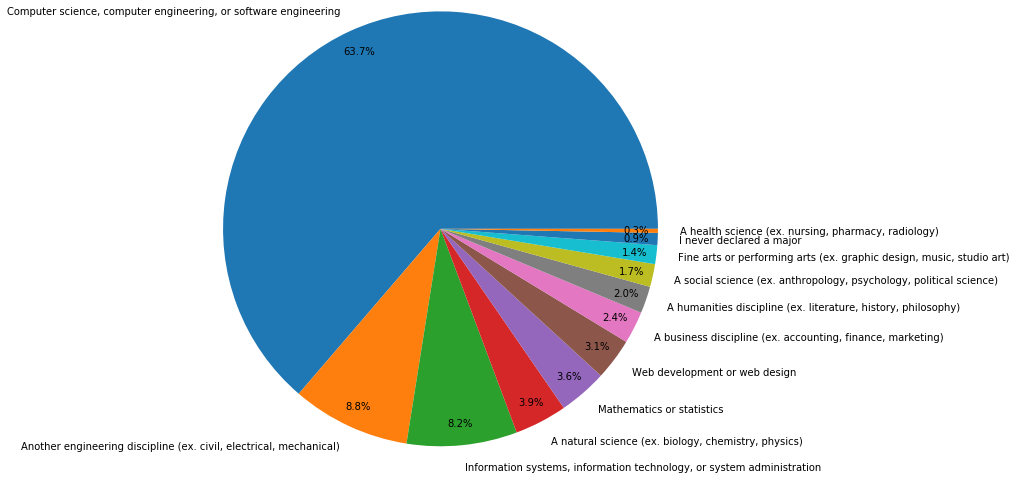

In [67]:
df_dropped_majors = data.dropna(subset=['UndergradMajor'])
ugrad_majors = pd.DataFrame(df_dropped_majors['UndergradMajor'].value_counts(normalize=True)*100).round(1)
ugrad_majors.columns=['Percentage'];
frame1 =ugrad_majors.plot.pie(y='Percentage', figsize=(5, 5),startangle=0,legend=None, autopct='%1.1f%%', pctdistance=0.9, radius=2);
frame1.axes.get_yaxis().set_visible(False)

<div class="span5 alert alert-success">
A lot of people from non-CS related backgrounds tend to switch to programming as a career. About 36% of developers didn't major in CS as undergraduates. With the rise of programming bootcamps, it is getting easier to switch to programming regardless of your background. Health science majors are least likely to switch to programming whereas STEM majors were much more likely to do the same. </div> 

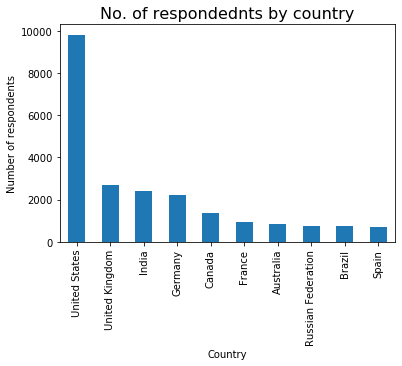

In [68]:
clean_df[clean_df['Country'].isin(top_countries.index)]['Country'].value_counts().plot(kind='bar');
_=plt.ylabel('Number of respondents');_=plt.xlabel('Country');_=plt.title('No. of respondednts by country',fontsize=16);

<div class="span5 alert alert-success">
Most of the respondents are from the US and many of the rest are from other western countries so we'd expect this dataset to heavily represent people living in Western democracies.</div>

<a id='Carsatvsother'></a> <font size="4"><b>Variables affecting Career Satisfaction </b>

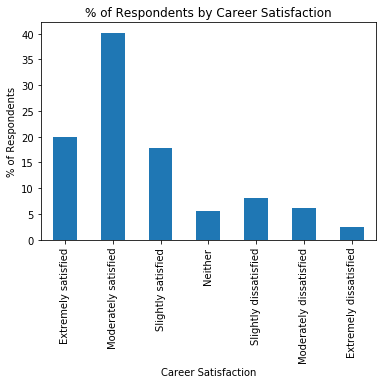

In [69]:
df_car_sat = pd.DataFrame(clean_df['CareerSatisfaction'].value_counts())
df_car_sat['% of Respondents'] = df_car_sat['CareerSatisfaction']*100/df_car_sat['CareerSatisfaction'].sum()
career_sat_order = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']#replace by car sat list
career_sat_order_short = [ 'Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']#replace by car sat list
dict_car_sat = {'Extremely satisfied':'Extremely satisfied','Moderately satisfied':'Moderately satisfied','Slightly satisfied':'Slightly satisfied','Neither satisfied nor dissatisfied':'Neither','Slightly dissatisfied':'Slightly dissatisfied', 'Moderately dissatisfied':'Moderately dissatisfied','Extremely dissatisfied':'Extremely dissatisfied'}
df_car_sat = df_car_sat.reindex(career_sat_order)
df_car_sat.rename(index=dict_car_sat,inplace=True)
df_car_sat_perc = df_car_sat[['% of Respondents']]
fig = df_car_sat_perc.plot(kind='bar');
plt.ylabel('% of Respondents');plt.xlabel('Career Satisfaction');
fig.get_legend().remove()
plt.title('% of Respondents by Career Satisfaction');

<div class="span5 alert alert-success">
About 40% of the people surveyed were moderately satisfied, and on a whole, about 75% of the people were satisfied to some extent with their jobs. About 17% were dissatisfied and the rest were neither. </div>

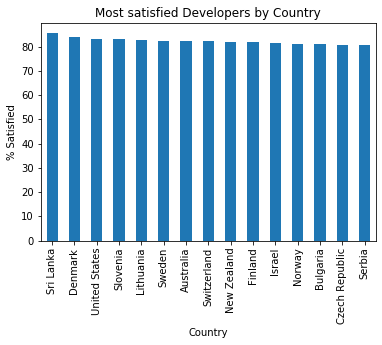

In [70]:
df_c = clean_df[clean_df['Country'].isin(countries_100_resp.index)];
df_c =df_c.groupby(['Country', 'CareerSatisfaction'])['Country'].count().unstack('CareerSatisfaction').fillna(0);df_c = satisfaction_perc(df_c);df_c['Country1']=df_c.index
df_c_sat = df_c.sort_values(by='% Satisfied',ascending=False).head(15);df_c_dis = df_c.sort_values(by='% Satisfied',ascending=False).tail(15)
fig =df_c_sat[['Country1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');fig.get_legend().remove();plt.ylabel('% Satisfied');plt.title('Most satisfied Developers by Country');

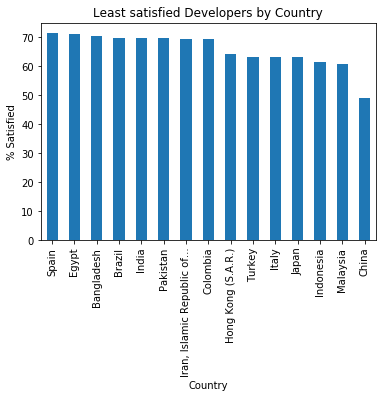

In [72]:
fig =df_c_dis[['Country1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove();plt.ylabel('% Satisfied'); plt.title('Least satisfied Developers by Country');

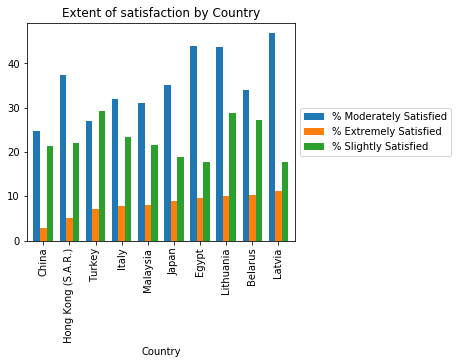

In [73]:
df_c_sorted =df_c.sort_values('% Extremely Satisfied',ascending=False);
fig = df_c_sorted[['% Moderately Satisfied','% Extremely Satisfied', '% Slightly Satisfied']].sort_values('% Extremely Satisfied',ascending=True).head(10).plot(kind='bar',width=.75) ;
box = fig.get_position();fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));plt.title('Extent of satisfaction by Country');

<div class="span5 alert alert-success">
Developers from non-western countries like Russia, Brazil and India are more likely to be sliglty satisfied whereas developers in western countries tend to be moderately or extremely satisfied by their jobs. We see an inverse relationship with Slight satisfaction and extreme satisfaction with the job. </div>

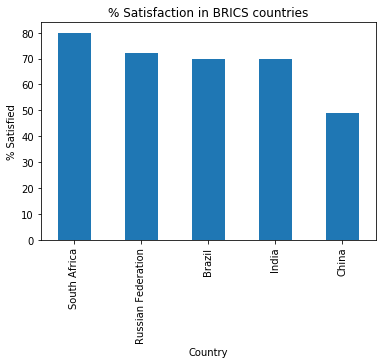

In [74]:
#Plotting satisfaction in BRICS countries
df_brics = clean_df[clean_df['Country'].isin(['Brazil','Russian Federation','India','China','South Africa'])]
df_brics =df_brics.groupby(['Country', 'CareerSatisfaction'])['Country'].count().unstack('CareerSatisfaction').fillna(0)
df_brics['Total'] = df_brics[['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']].sum(axis=1)
df_brics['Satisfied']=df_brics[['Extremely satisfied','Moderately satisfied','Slightly satisfied']].sum(axis=1)
df_brics['% Satisfied'] =  df_brics['Satisfied']*100/df_brics['Total'];df_brics['Country1']=df_brics.index
fig =df_brics[['Country1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove();plt.ylabel('% Satisfied');plt.title('% Satisfaction in BRICS countries');

<div class="span5 alert alert-success">
China has a much lower career satisfaction compared to other BRICS countries. </div>

In [75]:
df_c_100 = clean_df[clean_df['Country'].isin(countries_100_resp.index)];
df_c_100 =df_c_100.groupby(['Country', 'CareerSatisfaction'])['Country'].count().unstack('CareerSatisfaction').fillna(0);
df_c_100 = satisfaction_perc(df_c_100)
pd.DataFrame(df_c_100.iloc[:,9].sort_values(ascending=False)).head(10);

In [76]:
pd.DataFrame(df_c_100.iloc[:,9].sort_values(ascending=False)).tail(10)

,% Satisfied
Country,
Pakistan,69.633508
"Iran, Islamic Republic of...",69.594595
Colombia,69.421488
Hong Kong (S.A.R.),64.406780
Turkey,63.281250
Italy,63.146998
Japan,63.114754
Indonesia,61.458333
Malaysia,60.810811


<a id='Carsatvsother'></a> <font size="4"><b>Formal Education </b>

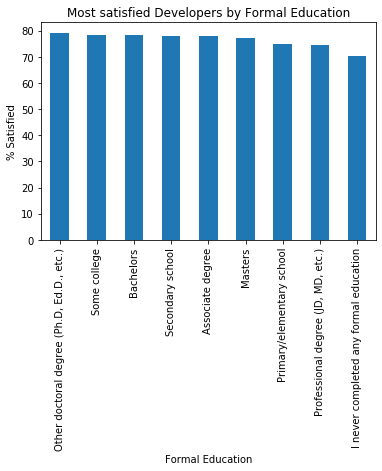

In [77]:
clean_df['FormalEducation'].replace(['Bachelors', 'Some college', 'Masters', 'Associate degree',       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',       'Professional degree (JD, MD, etc.)',       'Other doctoral degree (Ph.D, Ed.D., etc.)','Primary/elementary school','I never completed any formal education'],['Bachelors', 'Some college', 'Masters', 'Associate degree',       'Secondary school',       'Professional degree (JD, MD, etc.)',       'Other doctoral degree (Ph.D, Ed.D., etc.)',       'Primary/elementary school',       'I never completed any formal education'],inplace=True)
df_c = clean_df.copy()
df_c =df_c.groupby(['FormalEducation', 'CareerSatisfaction'])['FormalEducation'].count().unstack('CareerSatisfaction').fillna(0);
df_c = satisfaction_perc(df_c);df_c['FormalEducation1']=df_c.index
df_c_sat = df_c.sort_values(by='% Satisfied',ascending=False).head(15)
df_c_dis = df_c.sort_values(by='% Satisfied',ascending=False).tail(15)
fig =df_c_sat[['FormalEducation1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove();plt.ylabel('% Satisfied');plt.title('Most satisfied Developers by Formal Education');plt.xlabel('Formal Education');

<a id='Carsatvsother'></a> <font size="4"><b>Exercise </b>

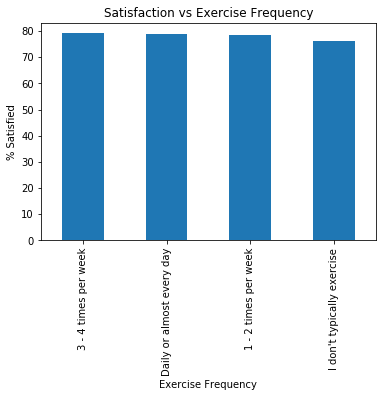

In [78]:
df_hr = clean_df.groupby(['Exercise', 'CareerSatisfaction'])['Exercise'].count().unstack('CareerSatisfaction').fillna(0);
df_hr = satisfaction_perc(df_hr)
df_hr = satisfaction_perc(df_hr);df_hr['Exercise1']=df_hr.index
fig =df_hr[['% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove();plt.ylabel('% Satisfied');plt.xlabel('Exercise Frequency');plt.title('Satisfaction vs Exercise Frequency');

In [79]:
#Extremely Satisfied vs the rest for all categories of exercise
crosstab = pd.crosstab(df_hr['Extremely satisfied'], df_hr['Total']-df_hr['Extremely satisfied'])
stats.chi2_contingency(crosstab)[1]

0.21330930508341653

In [80]:
#% who are Extremely Satisfied with 3-4 days of exercise vs % who are Extremely Satisfied with no exercise
satisfied = np.array([[10006,2039], [18319, 15019]]) #??? which numbers should I use
#[total_3-4_exercise,total_3-4_exercise_satisfied],[total_no_exercise,total_no_exercise_extremely satisfied]
stats.chi2_contingency(satisfied)[1]

0.0

In [81]:
#% who are Extremely dissatisfied with 3-4 days of exercise vs % who are Extremely dissatisfied with no exercise
dissatisfied = np.array([[10006,2039], [18319, 3300]])
#[total_dissatisfied,total_dissatisfied_excited],[total_other,total_not_dissatisfied_notexcited]
stats.chi2_contingency(dissatisfied)[1]
#*** bonferoni corection

6.598107110821082e-05

In [82]:
print("P-values between satisfaction of people who work out and those who don't (after applying Bonferroni Correction):{:0.2f}".format((6.598e-5+0+.21)/3))

P-values between satisfaction of people who work out and those who don't (after applying Bonferroni Correction):0.07


P-values between % of people who work out 3-4 times a day and are Extremely Satisfied and those who don't work out who are Extremely Satisfied is 6.5e-5 which is evidence that they are different populations and the relationship shown by the charts is meaningful.

<a id='Carsatvsother'></a> <font size="4"><b>Undergrad Major </b>

In [83]:
df_um = clean_df[clean_df['Country'].isin(top_20_countries.index)];
df_um = df_um.groupby(['UndergradMajor', 'CareerSatisfaction'])['UndergradMajor'].count().unstack('CareerSatisfaction').fillna(0);
df_um = satisfaction_perc(df_um)
df_um['UndergradMajor1']=df_um.index
df_um[['% Satisfied']].sort_values('% Satisfied',ascending=False)

CareerSatisfaction,% Satisfied
UndergradMajor,
"A social science (ex. anthropology, psychology, political science)",85.816876
"A humanities discipline (ex. literature, history, philosophy)",84.890966
I never declared a major,83.333333
"A health science (ex. nursing, pharmacy, radiology)",81.538462
"Fine arts or performing arts (ex. graphic design, music, studio art)",81.120332
"A business discipline (ex. accounting, finance, marketing)",80.827068
"A natural science (ex. biology, chemistry, physics)",79.840142
Mathematics or statistics,79.513185
Web development or web design,78.283713


In [84]:
df_um.index = ['A business discipline', 'A health science','A humanities discipline','A natural science','A social science',     
       'Another engineering discipline','CS, computer/software eng.','Fine arts/performing arts','I never declared a major',
       'Info. systems/IT/system admin.','Mathematics/tatistics', 'Web development/design']       

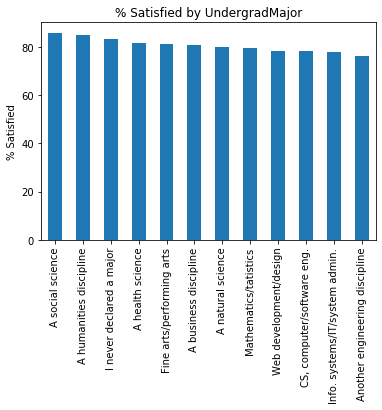

In [85]:
fig =df_um[['UndergradMajor1','% Satisfied']].sort_values('% Satisfied',ascending=False).plot(kind='bar');
fig.get_legend().remove()
plt.ylabel('% Satisfied');
plt.title('% Satisfied by UndergradMajor');

In [86]:
df_um[['Total','Extremely dissatisfied','Extremely satisfied']]

CareerSatisfaction,Total,Extremely dissatisfied,Extremely satisfied
A business discipline,532,8,129
A health science,65,3,16
A humanities discipline,642,15,169
A natural science,1126,15,243
A social science,557,4,155
Another engineering discipline,2000,38,375
"CS, computer/software eng.",15457,366,3104
Fine arts/performing arts,482,7,115
I never declared a major,198,6,59
Info. systems/IT/system admin.,1811,52,314


In [87]:
#% CS majors who are Extremely Satisfied  vs % social science majors who are Extremely Satisfied
dissatisfied = np.array([[22126,4262], [713, 190]])
pval = stats.chi2_contingency(dissatisfied)[1]
#***t test  by passing vectors
print("P-values between satisfaction of people who Majored in CS vs those in Social Sciences is: {:0.2f}".format(pval));print('Hence, the populations are distinct.')

P-values between satisfaction of people who Majored in CS vs those in Social Sciences is: 0.00
Hence, the populations are distinct.


P-values between % of CS Majors who are Extremely Satisfied and Social Science Majors who are Extremely Satisfied is 0.0001 which is evidence that they are different populations and the relationship shown by the charts is meaningful. ???* should I create a table with all p values I found and put it in the report.

<div class="span5 alert alert-success">
Developers who did not major in CS or another STEM degree are happier than developers who majored in CS or STEM fields. And people who make a bigger switch (i.e. from sociology to CS vs Math to CS) are happier.  </div>

<font size="3"><b>Hobby </b>

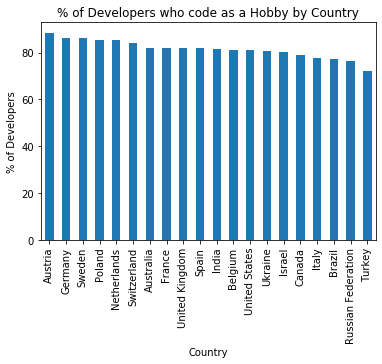

In [88]:
df1 = clean_df[clean_df['Country'].isin(top_20_countries.index)] 
df2 =df1.groupby(['Country', 'Hobby'])['Country'].count().unstack('Hobby').fillna(0)
df2['Total']=df2['No']+df2['Yes']
df2['% Yes'] = df2['Yes']*100/df2['Total']
df2['% No']=100-df2['% Yes']
df3 = df2.sort_values(by='Total',ascending=False)
fig=df3[['% Yes']].sort_values('% Yes',ascending=False).plot(kind='bar', stacked=True) 
plt.title('% of Developers who code as a Hobby by Country'); 
plt.ylabel('% of Developers')
fig.get_legend().remove()

<div class="span5 alert alert-success">
Developers from european countries are more likely to program as a hobby. It's also interesting to see that the more people code as a hobby, the more likely they are to be satisfied with their career (comparing with plot above). Russia, India and Brazil lag behind many of their western counterparts in job satisfaction.</div>

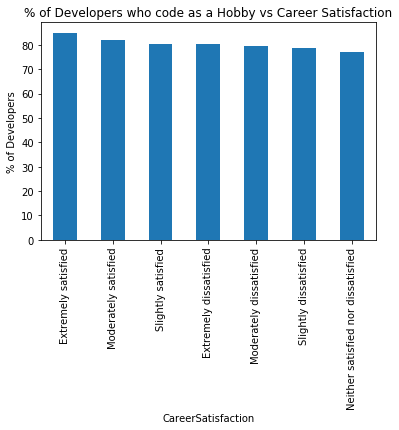

In [89]:
df2 =df1.groupby(['CareerSatisfaction', 'Hobby'])['CareerSatisfaction'].count().unstack('Hobby').fillna(0)
df2['Total']=df2['No']+df2['Yes']
df2['% Yes'] = df2['Yes']*100/df2['Total']
df2['% No']=100-df2['% Yes']
df3 = df2.sort_values(by='Total',ascending=False)
fig=df3[['% Yes']].sort_values('% Yes',ascending=False).plot(kind='bar', stacked=True) 
plt.title('% of Developers who code as a Hobby vs Career Satisfaction'); 
plt.ylabel('% of Developers')
fig.get_legend().remove()

In [90]:
df3t = df3.T;df3t['Total']=df3t.sum(axis=1)
df3t[['Total','Extremely satisfied']].iloc[:3,:]

CareerSatisfaction,Total,Extremely satisfied
Hobby,,
No,4857.0,813.0
Yes,21552.0,4612.0
Total,26409.0,5425.0


In [91]:
#% who code as a hobby and are Extremely Satisfied  vs % rest 
dissatisfied = np.array([[31408,6494], [7416, 1166]])
#[total_satisfied_hobby,total_satisfied_excited],[tptal_not_satisfied,total_not_satisfied_notexcited]
pval = stats.chi2_contingency(dissatisfied)[1]
print("P-values between satisfaction of people who code as a hobby and who don't is: {:0.2f}".format(pval));print('Hence, the populations are distinct.')

P-values between satisfaction of people who code as a hobby and who don't is: 0.00
Hence, the populations are distinct.


P-values between Extremely satisfied who code as a hobby and who dont code as a hobby who are Extremely Satisfied is 0.023 which is evidence that they are different populations and the relationship shown by the charts is meaningful.

<div class="span5 alert alert-success">
We can see a  clear relationship here. Developers who code as a hobby are more likely to be satisfied with their career. However, it’s interesting to see that people who are extremely dissatisfied are more likely to code as a hobby than those who are moderately or slightly dissatisfied. </div>
    </div>

<font size="3"><b>Years of Coding Experience</b>

In [92]:
usdata = data[data.Country == 'United States'].dropna(subset=['DevType','ConvertedSalary','YearsCoding']);
usdatacopy = usdata.copy()

In [93]:
#Convert Years of Coding in USA to numeric variable
if 'YearsCoding' in usdata.columns:
    years = usdata['YearsCoding'].unique()
    yrs_num =[10,30,19,4,7,13,16,1,22,25,28]
    yrs_cod_ser = seriesify(usdata,years,yrs_num,'YearsCoding')
    usdata=dummify(usdata,'YearsCoding',yrs_cod_ser)

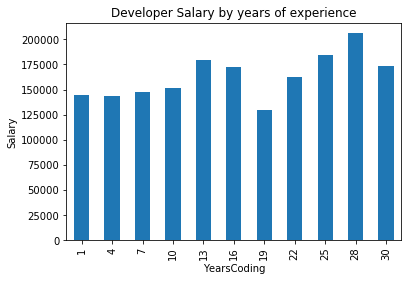

In [94]:
#clean_df_dev[clean_df_dev.DevType.isin(dev_types_single)].groupby(['DevType']).count();
df_dev =  clean_df.copy() 
df_dev.dropna(subset=['ConvertedSalary'],inplace=True)
if 'YearsCoding' in df_dev.columns:
    years = df_dev['YearsCoding'].unique()
    yrs_num =[30,7,10,16,13,4,1,19,25,22,28]
    yrs_cod_ser = seriesify(df_dev,years,yrs_num,'YearsCoding')
    df_dev=dummify(df_dev,'YearsCoding',yrs_cod_ser)
df_dev[df_dev.Country == 'United States'].groupby(['YearsCoding_n'])['ConvertedSalary'].mean().plot(kind='bar');
plt.ylabel('Salary');plt.xlabel('YearsCoding');plt.title('Developer Salary by years of experience');

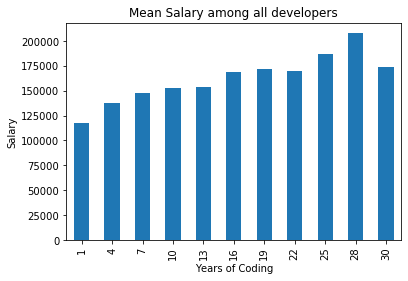

In [95]:
usdata_plt =usdata.groupby(['YearsCoding_n'])['ConvertedSalary'].mean().sort_index().plot(kind='bar');plt.title('Mean Salary among all developers');plt.ylabel('Salary');plt.xlabel('Years of Coding');

<div class="span5 alert alert-success">
More experience generally (but not always) mean a higher salary. Developer type aso plays a role in determining the salary. </div>

In [96]:
dev_types_single = ['Full-stack developer','Back-end developer','Mobile developer','Front-end developer','Data scientist or machine learning specialist','Desktop or enterprise applications developer','Embedded applications or devices developer']

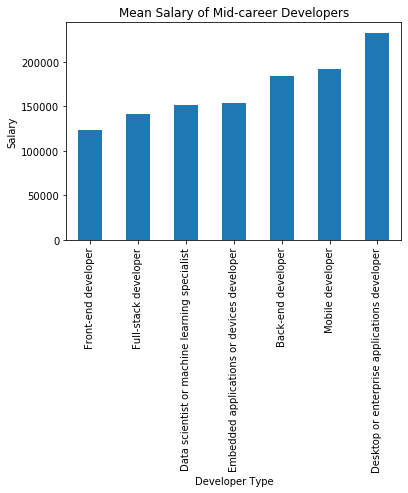

In [97]:
#Controlling for years coding, plot salaries by developer type.
usdata[usdata.DevType.isin(dev_types_single) & (usdata.YearsCoding_n == 7)].groupby(['DevType'])['ConvertedSalary'].mean().sort_values().plot(kind='bar');plt.title('Mean Salary of Mid-career Developers');plt.ylabel('Salary');plt.xlabel('Developer Type');

<div class="span5 alert alert-success">
Desktop or enterprise applications developer are the highest paid (among mid career people with 6-8 years of experience). </div>

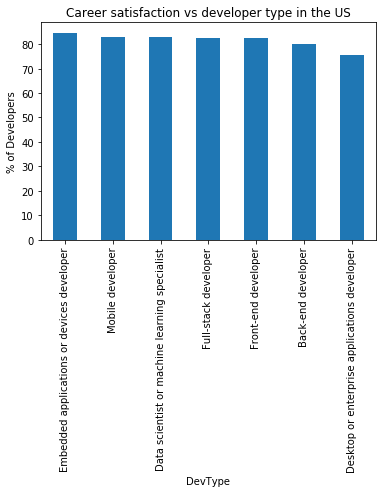

In [98]:
#Career satisfaction vs developer type in the US
us_cs = usdata[usdata.DevType.isin(dev_types_single)].groupby(['DevType', 'CareerSatisfaction'])['DevType'].count().unstack('CareerSatisfaction').fillna(0)
us_cs = satisfaction_perc(us_cs)
us_cs['% Satisfied'].sort_values(ascending=False).plot(kind='bar');plt.title('Career satisfaction vs developer type in the US');plt.ylabel('% of Developers');

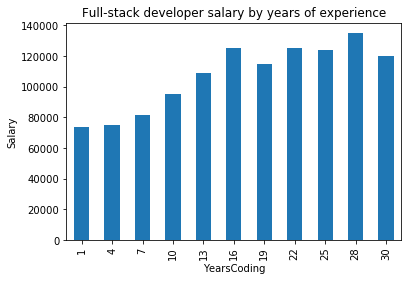

In [99]:
usdata_singledt = usdata[usdata.DevType.isin(dev_types_single)]
usdata_singledt.dropna(subset=['ConvertedSalary'],inplace=True)
usdata_singledt[usdata_singledt.DevType=='Full-stack developer'].groupby(['YearsCoding_n'])['ConvertedSalary'].median().plot(kind='bar');
plt.ylabel('Salary');plt.xlabel('YearsCoding');plt.title('Full-stack developer salary by years of experience');

<div class="span5 alert alert-success">
Years of coding (when controlling for country and developer type does matter when it comes to income. The rise in salary is higher in the beginning. </div>

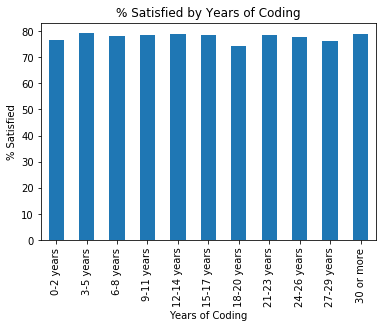

In [100]:
df_yc = pd.concat([df.iloc[:,0:22],clean_df],axis=1)
df_yc = df_yc.groupby(['YearsCoding_n', 'CareerSatisfaction'])['YearsCoding_n'].count().unstack('CareerSatisfaction').fillna(0);
df_yc = satisfaction_perc(df_yc);fig =df_yc[['% Satisfied']].plot(kind='bar');fig.get_legend().remove();
fig.set_xticklabels(['0-2 years','3-5 years','6-8 years','9-11 years','12-14 years','15-17 years', '18-20 years'
                     , '21-23 years',  '24-26 years' , '27-29 years','30 or more']);plt.ylabel('% Satisfied');plt.xlabel('Years of Coding');plt.title('% Satisfied by Years of Coding');

<div class="span5 alert alert-success">
Years of coding doesn't seem to have a clear effect on career satisfaction. The only major change that can be seen is a drop in satisfaction after the initial 0-2 years, and then again after 3-5 years. One explanation could be that developers are initially excited with their new careers/jobs and hence the high career satisfaction.</div>

<font size="3"><b>Company Size</b>

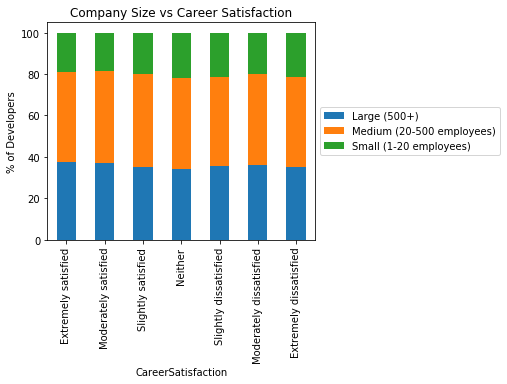

In [101]:
df_comp =clean_df.groupby(['CompanySize','CareerSatisfaction'])['CompanySize'].count().unstack('CareerSatisfaction').fillna(0)
order = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']
xtixks_car_sat = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']
df_comp=df_comp[order]
df_comp1=df_comp.copy()
df_comp = df_comp.T
df_comp['Total'] = df_comp.sum(axis=1);#['10,000 or more employees', '10 to 19 employees','100 to 499 employees', '1,000 to 4,999 employees','20 to 99 employees', '500 to 999 employees','5,000 to 9,999 employees', 'Fewer than 10 employees'].sum(axis=1)
df_comp['Large (500+)'] = (df_comp['10,000 or more employees']+df_comp['1,000 to 4,999 employees']+ df_comp['5,000 to 9,999 employees']+ df_comp['500 to 999 employees'])*100/(df_comp['Total'])
df_comp['Medium (20-500 employees)'] = (df_comp['100 to 499 employees']+df_comp['20 to 99 employees'])*100/df_comp['Total']
df_comp['Small (1-20 employees)']=100-df_comp['Large (500+)']-df_comp['Medium (20-500 employees)']
df_comp.rename(index=dict_car_sat,inplace=True)
fig = df_comp[['Large (500+)','Medium (20-500 employees)','Small (1-20 employees)']].plot(kind='bar',stacked=True);
box = fig.get_position();plt.ylabel('% of Developers')
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));plt.xticks=xtixks_car_sat;plt.title('Company Size vs Career Satisfaction');

In [102]:
df_comp_t = df_comp.T;df_comp_t.columns=order;df_comp_t = satisfaction_perc(df_comp_t);df_comp_t.iloc[-3:,-5:];

In [103]:
df_comp['Total']

CareerSatisfaction
Extremely satisfied         6445
Moderately satisfied       13030
Slightly satisfied          5755
Neither                     1778
Slightly dissatisfied       2644
Moderately dissatisfied     1982
Extremely dissatisfied       787
Name: Total, dtype: int64

In [104]:
df_comp['Large'] = (df_comp['10,000 or more employees']+df_comp['1,000 to 4,999 employees']+ df_comp['5,000 to 9,999 employees']+ df_comp['500 to 999 employees'])
df_comp['Medium'] = (df_comp['100 to 499 employees']+df_comp['20 to 99 employees'])
df_comp['Small'] = df_comp['Total'] -(df_comp['Large']+df_comp['Medium']);

In [105]:
print("P-values between satisfaction of people who code as a hobby and who don't is: {:0.2f}".format(pval));print('Hence, the populations are distinct.')

P-values between satisfaction of people who code as a hobby and who don't is: 0.00
Hence, the populations are distinct.


In [106]:
df_comppv = df_comp[['Large','Medium','Small','Total']];
df_comppv

CompanySize,Large,Medium,Small,Total
CareerSatisfaction,,,,
Extremely satisfied,2416,2799,1230,6445
Moderately satisfied,4839,5801,2390,13030
Slightly satisfied,2022,2595,1138,5755
Neither,607,784,387,1778
Slightly dissatisfied,942,1135,567,2644
Moderately dissatisfied,718,866,398,1982
Extremely dissatisfied,275,345,167,787


In [107]:
df_comppv.sum(axis=0)

CompanySize
Large     11819
Medium    14325
Small      6277
Total     32421
dtype: int64

In [108]:
# People in large companies vsthose in maedium (extremely satisfied) 
dissatisfied = np.array([[17384,3404], [21344, 4020]]);
#[total_satisfied_hobby,total_satisfied_excited],[tptal_not_satisfied,total_not_satisfied_notexcited]
pval = stats.chi2_contingency(dissatisfied)[1];pval

0.12943038033797102

In [109]:
# People in large companies vsthose in maedium (extremely satisfied) 
dissatisfied = np.array([[21344,4020], [10215, 1977]]);
#[total_satisfied_hobby,total_satisfied_excited],[tptal_not_satisfied,total_not_satisfied_notexcited]
pval = stats.chi2_contingency(dissatisfied)[1];pval

0.3721849540709775

In [110]:
#% who code as a hobby and are Extremely Satisfied  vs % rest 
dissatisfied = np.array([[31408,6494], [7416, 1166]])
#[total_satisfied_hobby,total_satisfied_excited],[tptal_not_satisfied,total_not_satisfied_notexcited]
pval = stats.chi2_contingency(dissatisfied)[1]
print("P-values between satisfaction of people who work at Large/Medium/Small companies is: {:0.2f}".format(.25));print("Hence, there's no concusive evidence that the populations are distinct and if career satisfaction is affected by company size.")

P-values between satisfaction of people who work at Large/Medium/Small companies is: 0.25
Hence, there's no concusive evidence that the populations are distinct and if career satisfaction is affected by company size.


<div class="span5 alert alert-success">
Company size doesn't seem to play a major role in career satisfaction.</div>

<font size="3"><b>Views on AI's future</b>

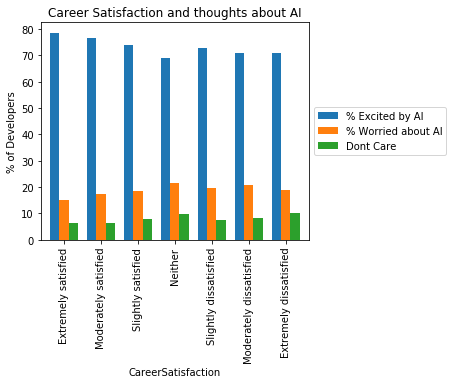

In [111]:
#Plot Career satisfaction by AI future
df_ai = clean_df[clean_df['Country'].isin(top_countries.index)]
df_ai =df_ai.groupby(['AIFuture','CareerSatisfaction'])['AIFuture'].count().unstack('CareerSatisfaction').fillna(0)
order = ['Extremely satisfied','Moderately satisfied','Slightly satisfied','Neither satisfied nor dissatisfied','Slightly dissatisfied', 'Moderately dissatisfied','Extremely dissatisfied']
df_ai=df_ai[order]
df_ai.columns = df_ai.columns.to_series().map(dict_car_sat)
df_ai = df_ai.T
df_ai['% Excited by AI'] = df_ai['Excited']*100/(df_ai['Excited']+df_ai['Worried']+df_ai['DontCare'])
df_ai['% Worried about AI'] = df_ai['Worried']*100/(df_ai['Excited']+df_ai['Worried']+df_ai['DontCare'])
df_ai['Dont Care'] = 100 - df_ai['% Excited by AI'] - df_ai['% Worried about AI'] 
fig = df_ai.drop(['DontCare','Excited','Worried'],axis=1).plot(kind='bar',width = .75)
box = fig.get_position();fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);plt.ylabel('% of Developers')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));plt.title('Career Satisfaction and thoughts about AI');

In [112]:
df_ait = df_ai[['DontCare','Excited','Worried']].T;df_ait['Total']=df_ait.sum(axis=1);df_ait

CareerSatisfaction,Extremely satisfied,Moderately satisfied,Slightly satisfied,Neither,Slightly dissatisfied,Moderately dissatisfied,Extremely dissatisfied,Total
AIFuture,,,,,,,,
DontCare,308,566,294,112,136,106,50,1572
Excited,3762,7025,2785,791,1296,935,346,16940
Worried,715,1602,697,245,347,275,93,3974


In [113]:
#proportion of people who are excited by AI and are Extremely Satisfied  vs % who are worried by AI who are Extremely Satisfied
satisfied = np.array([[23795,5147], [6147, 1121]]);pval = stats.chi2_contingency(satisfied)[1]
#[total_ext_satisfied,total_ext_satisfied_excited],[total_mod_satisfied,total_not_satisfied_notexcited]
print("P-values between proportion of people who are excited by AI and are Extremely Satisfied  vs those who are worried is {:0.2f}".format(pval));print("Hence, the difference is statistically significant.");

P-values between proportion of people who are excited by AI and are Extremely Satisfied  vs those who are worried is 0.00
Hence, the difference is statistically significant.


In [114]:
import numpy as np
count = np.array([5147, 1121]);nobs = np.array([23795, 6147]);stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))#***

0.000


<div class="span5 alert alert-success">
As career satisfaction decreases, excitement about AI's future also decreases. Those who are indifferent about their career satisfaction are least excited by  AI.</div>

<font size="3"><b>Calling out unethical code </b>

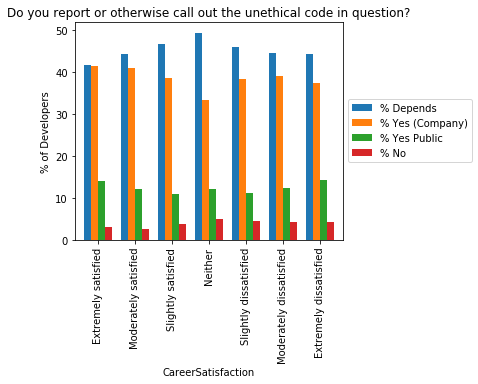

In [115]:
df_ethr =clean_df.groupby(['EthicsReport','CareerSatisfaction'])['EthicsReport'].count().unstack('CareerSatisfaction').fillna(0)
df_ethr=df_ethr[order];df_ethr.rename(index=dict_car_sat,inplace=True);df_ethr_t=df_ethr.T
df_ethr_t['Total']=df_ethr_t[['Depends on what it is', 'Yes, but only within the company','Yes, and publicly', 'No']].sum(axis=1)
df_ethr_t['% Depends'] = df_ethr_t['Depends on what it is']*100/df_ethr_t['Total']
df_ethr_t['% Yes (Company)']=df_ethr_t['Yes, but only within the company']*100/df_ethr_t['Total']
df_ethr_t['% Yes Public']=df_ethr_t['Yes, and publicly']*100/df_ethr_t['Total']
df_ethr_t['% No']=df_ethr_t['No']*100/df_ethr_t['Total'];df_ethr_t.rename(index=dict_car_sat,inplace=True)
fig = df_ethr_t.drop(['Yes, and publicly','Yes, but only within the company','Depends on what it is', "No",'Total'],axis=1).plot(kind='bar',width = .75)
box = fig.get_position();fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));plt.ylabel('% of Developers');plt.title('Do you report or otherwise call out the unethical code in question?');

In [116]:
df_ethr_t[['Yes, but only within the company','Yes, and publicly','Total']]

EthicsReport,"Yes, but only within the company","Yes, and publicly",Total
CareerSatisfaction,,,
Extremely satisfied,2666,910,6445
Moderately satisfied,5328,1581,13030
Slightly satisfied,2226,624,5755
Neither,594,216,1778
Slightly dissatisfied,1016,296,2644
Moderately dissatisfied,774,243,1982
Extremely dissatisfied,294,112,787


In [117]:
dissatisfied = np.array([[9401,3785], [1350, 492]]);pval = stats.chi2_contingency(dissatisfied)[1];
#[total_ext_satisfied,total_ext_satisfied_yes_company],[total_ext_dissatisfied,total_ext_dissatisfied_yes_company#???
print("P-values between proportion of people who are Extrememly Satisfied who would report unethical code within the company vs the same who are Extremely Dissatisfied is {:0.2f}".format(pval));print("Hence, the difference isn't statistically significant.");

P-values between proportion of people who are Extrememly Satisfied who would report unethical code within the company vs the same who are Extremely Dissatisfied is 0.08
Hence, the difference isn't statistically significant.


In [118]:
dissatisfied = np.array([[9401,1304], [19014, 7515]]);pval = stats.chi2_contingency(dissatisfied)[1];
#[total_ext_satisfied,total_ext_satisfied_yes_company],[total_ext_dissatisfied,total_ext_dissatisfied_yes_company#???
print("P-values between proportion of people who are Extrememly Satisfied who would report unethical code within the company vs the same who are Moderately Satisfied is {:0.2f}".format(pval));print("Hence, the difference is statistically significant.");

P-values between proportion of people who are Extrememly Satisfied who would report unethical code within the company vs the same who are Moderately Satisfied is 0.00
Hence, the difference is statistically significant.


P-values between Extremely satisfied and Extremely DIssatisfied is 0.08 which is not conclusive evidence that they are different populations and the relationship shown by the charts is meaningful. ???

<div class="span5 alert alert-success">
People who are either extremely satisfied or dissatisfied are more likely to publicly call out unethical code. But people who are satisfied tend to call out unethical code within their company more often than those who arent.  </div>

<font size="3"><b>Considering Ethics at work</b>

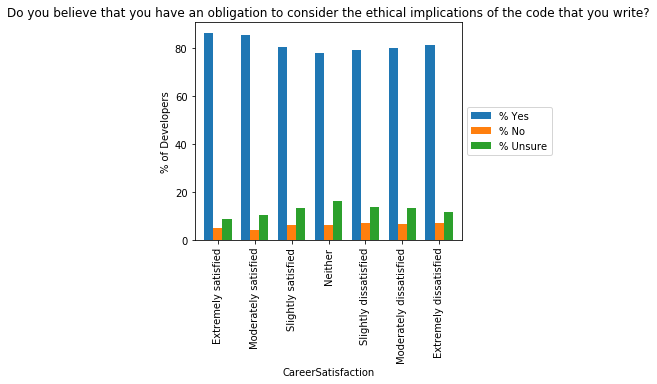

In [119]:
df_eth =clean_df.groupby(['EthicalImplications','CareerSatisfaction'])['EthicalImplications'].count().unstack('CareerSatisfaction').fillna(0)
df_eth=df_eth[order];df_eth_t=df_eth.T;df_eth_t['Total']=df_eth_t[['Yes',"Unsure / I don't know",'No']].sum(axis=1)
df_eth_t['% Yes']=df_eth_t['Yes']*100/df_eth_t['Total'];df_eth_t['% No']=df_eth_t['No']*100/df_eth_t['Total']
df_eth_t['% Unsure'] = 100-df_eth_t['% No']-df_eth_t['% Yes'];df_eth_t.rename(index=dict_car_sat,inplace=True)
fig = df_eth_t.drop(['Yes', "Unsure / I don't know", 'No','Total'],axis=1).plot(kind='bar',width = .75)
box = fig.get_position();fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.ylabel('% of Developers')
plt.title('Do you believe that you have an obligation to consider the ethical implications of the code that you write?');

In [120]:
dissatisfied = np.array([[9401,508], [1067, 93]]) #[total_satisfied,total_satisfied_excited],[tptal_not_satisfied,total_not_satisfied_notexcited]
pval = stats.chi2_contingency(dissatisfied)[1] 
print("P-values between the proportion of people who are Extremely Satisfied who would consider ethical implications of their code vs the same who are Extremely Dissatisfied is {:0.2f}".format(pval));print("Hence, the difference is statistically significant.");

P-values between the proportion of people who are Extremely Satisfied who would consider ethical implications of their code vs the same who are Extremely Dissatisfied is 0.00
Hence, the difference is statistically significant.


P-values between Extremely satisfied and Extremely DIssatisfied is .19 which is not conclusive evidence that they are different populations and the relationship shown by the charts is meaningful. ???

<div class="span5 alert alert-success">
People who are more satisfied  with their career tend to consider ethical implications of their code more than those who aren't.</div>

<font size="3"><b>Wake time</b>

In [121]:
#Wake time correlation with career satisfaction
df_wt =clean_df.groupby(['WakeTime','CareerSatisfaction'])['WakeTime'].count().unstack('CareerSatisfaction').fillna(0)
df_wt=df_wt[order];df_wt = df_wt.iloc[4:10,:];df_wt_t=df_wt.T;df_wt_t['Total']=df_wt_t.sum(axis=1);
df_wt_t.iloc[:,0]=df_wt_t.iloc[:,0]*100/df_wt_t.iloc[:,6];df_wt_t.iloc[:,1]=df_wt_t.iloc[:,1]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,2]=df_wt_t.iloc[:,2]*100/df_wt_t.iloc[:,6];df_wt_t.iloc[:,3]=df_wt_t.iloc[:,3]*100/df_wt_t.iloc[:,6]
df_wt_t.iloc[:,4]=df_wt_t.iloc[:,4]*100/df_wt_t.iloc[:,6];df_wt_t.iloc[:,5]=df_wt_t.iloc[:,5]*100/df_wt_t.iloc[:,6]

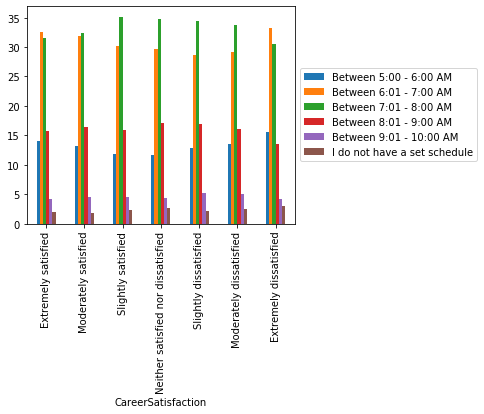

In [122]:
fig = df_wt_t.iloc[:,:6].plot(kind='bar');box = fig.get_position();
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height]);fig.legend(loc='center left', bbox_to_anchor=(1, 0.5));

<div class="span5 alert alert-success">
Most developers wake up vetween 5-7 am. Developers who wake up earlier (5-6 am) are more likely to either be really satisfied or really dissatisfied with their careers. </div>

<font size="3"><b>Developer Type</b>

In [123]:
%time
dev_type = pd.DataFrame(clean_df['DevType'].str.split(';'))
dev_type.columns=['DeveloperType']
devtype_df = pd.concat([clean_df,dev_type],axis=1)
x=0
single_devtype=[]
devtype_df=devtype_df.reset_index()
for i in range(len(devtype_df)):
    if len(devtype_df['DeveloperType'][i]) == 1:
        single_devtype.append(devtype_df.loc[i])

Wall time: 0 ns


In [124]:
single_devtype = pd.DataFrame(single_devtype);single_devtype_cs = single_devtype[['DeveloperType', 'CareerSatisfaction']];single_devtype_cs['DevType']=single_devtype_cs['DeveloperType'].apply(', '.join);
single_devtype_cs=single_devtype_cs.groupby(['DevType', 'CareerSatisfaction'])['DevType'].count().unstack('CareerSatisfaction')

In [125]:
single_devtype_cs = satisfaction_perc(single_devtype_cs); 
single_devtype_cs['% Extremely Dissatisfied'] = single_devtype_cs['Extremely dissatisfied']*100/single_devtype_cs['Total'];
single_devtype_cs['% Neither'] = single_devtype_cs['Neither satisfied nor dissatisfied']*100/single_devtype_cs['Total'];

In [126]:
single_devtype_cs.drop(['Marketing or sales professional'],inplace=True)

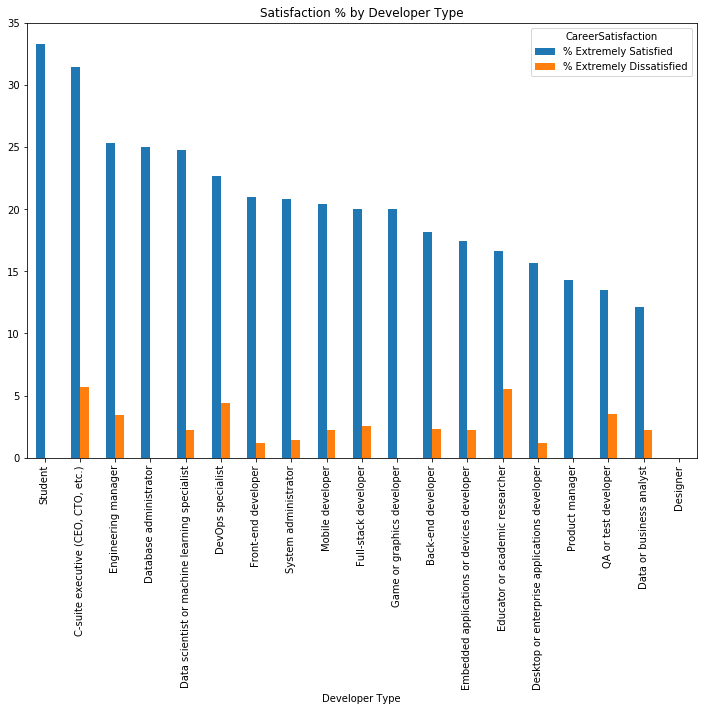

In [127]:
#Shorten developer type to make plot look better
#single_devtype_cs.index=(['Back-end developer', 'CEO, CTO, etc.',  'Data or business analyst',       'Data scientist or ML specialist',       'Desktop/enterprise app. dev.', 'DevOps specialist',       'Embedded app./devices dev.', 'Engineering manager', 'Front-end developer', 'Full-stack developer', 'Mobile developer', 'QA or test developer', 'System administrator'])
fig = single_devtype_cs[['% Extremely Satisfied','% Extremely Dissatisfied']].sort_values('% Extremely Satisfied',ascending=False).plot(kind='bar', stacked=False ,figsize=(12,8)) ;
box = fig.get_position();fig.set_position([box.x0, box.y0, box.width, box.height]);plt.title('Satisfaction % by Developer Type');plt.xlabel('Developer Type');

In [128]:
# Proportion of CEOs who are Extremely Satisfied vs that of others who are Extremely Satisfied
satisfied = np.array([[118,39], [13602, 2534]]); #??? which numbers should I use
stats.chi2_contingency(satisfied)[1]

0.0025759663714043225

<div class="span5 alert alert-success">
Among non-managerial roles, data scientist or ML specialists are the most satisfied with their jobs whereas data/business analysts are the least satisfied. This is interesting because to many people, they're very similar jobs, but in fact they work with data very differently and do very different things with it.</div>

<font size="5"><a id='MachineLearning'></a> <b>5 Machine Learning (In Progress)</b><br>
<font size="2.5">[5.1 Logistic Regression](#logreg)<br>
    [5.2 Random Forest](#rf)<br>
    [5.3 KNN](#knn)<br>
    

In [129]:
#df = df[df.Country == 'United States']
df_no_dev = pd.concat([df.iloc[:,13:26]],axis=1) #feature variable DF without devtype and career satisfaction . ****
df_dev = df.iloc[:,18:-1] #pd.concat([df_no_dev,df.iloc[:,26:]],axis=1)
target = df.iloc[:,-1:]

In [130]:
df_car_sat_y = df['CareerSatisfaction_n'] #target var career sat

In [131]:
df_total = df_dev#pd.concat([df_dev,df_car_sat_y],axis=1)#Data frame to test ML  ***

In [132]:
df_dev.shape

(30043, 95)

In [133]:
###-------------- defining variables with STANDARD SCALAR --------------
from sklearn.preprocessing import StandardScaler
#Career Satisfaction variables
dflr = df_dev.copy();#dflr.drop(columns=['Continent'],inplace=True);
target.replace([3,0,-1,2,1,-2,-3] ,[0,0,0,0,0,0,1] ,inplace=True) 
val0lr = df_dev.iloc[:,:-1].values #returns a numpy array

scaler = StandardScaler();val0lr = scaler.fit_transform(val0lr);dflr_norm0 = pd.DataFrame(val0lr)

X = dflr_norm0;y = target;
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [134]:
from xgboost import XGBClassifier

In [135]:
model = XGBClassifier()#*****gridsearch
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.59%


In [136]:
confusion_matrix(y_test, y_pred)

array([[5864,    0],
       [ 145,    0]], dtype=int64)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
logistic = LogisticRegression(C=1,penalty='l1').fit(X_train, y_train)
y_pred = logistic.predict(X_test)
pp = logistic.predict_proba(X_test)
accuracy = logistic.score(X_test,y_test)
print('Logistic Regression Score: {:0.2f}%'.format(accuracy*100)) 

Logistic Regression Score: 97.59%


In [138]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [139]:
confusion_matrix(y_test, y_pred)

array([[5864,    0],
       [ 145,    0]], dtype=int64)

In [140]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = dflr.iloc[:,:-1].columns

In [141]:
vif.sort_values(by='VIF Factor',ascending=False) #**** ??? 

,VIF Factor,features
81,118.225327,Bachelors
82,87.725244,Masters
87,50.949702,Some college
21,47.173188,My job status or other personal status changed
18,24.331194,I had a negative experience or interaction at ...
...,...,...
49,1.022471,Cobol
7,1.022356,AIFuture_n
9,1.017423,TimeFullyProductive_n
10,1.011790,HoursComputer_n


In [142]:
pp = pd.DataFrame(pp).iloc[:,:2];y_testdf = pd.DataFrame(y_test);y_testdf.reset_index(inplace=True)
ppdf = pd.concat([pp,y_testdf],axis=1);ppdf.columns=['1', 'level_0', 'index', 'CareerSatisfaction_n'];ppdf = ppdf[['1', 'CareerSatisfaction_n']]
ppdf.sort_values(by='1',ascending=False,inplace=True)
#Top Deciles 
t10 = ppdf.iloc[:980,:];t10_20 = ppdf.iloc[980:1960,:];t20_30 = ppdf.iloc[1960:2940,:];t30_40 = ppdf.iloc[2940:3920,:];
t_last = ppdf.iloc[8820:,:];
print('first decile: ' + str(len(t10[t10.CareerSatisfaction_n == 1].index)))
print('2nd decile: ' + str(len(t10_20[t10_20.CareerSatisfaction_n == 1].index)))
print('3rd decile: ' + str(len(t20_30[t20_30.CareerSatisfaction_n == 1].index)))
print('4th decile: ' + str(len(t30_40[t30_40.CareerSatisfaction_n == 1].index)))
print('last decile: ' + str(len(t_last[t_last.CareerSatisfaction_n == 1].index)))

first decile: 19
2nd decile: 17
3rd decile: 19
4th decile: 19
last decile: 0


In [143]:
confusion_matrix(y_test[['CareerSatisfaction_n']], y_pred)

array([[5864,    0],
       [ 145,    0]], dtype=int64)

In [144]:
###########################      VARIABLE DEFINITIONS         #################################
#x0 = CompanySize_n,YearsCoding_n,HoursOutside_n,Exercise_n,AIFuture_n,WakeTime_n,Hobby_Yes,OpenSource_Yes,EthicalImplications_n,EthicsReport_n
#y0 = CareerSatisfaction_n
#***xgboost, analytical logistical regression,vif scores, followerwonk,wine quality

<div class="span5 alert alert-success">
<b>Precision vs Recall</b><br>
Since it's crucial to detect all dissatisfied employees, and it's better to take action to increase satisfaction of someone who's already satisfied, rather than miss someone who is dissatisfied, recall is more important. If we miss some dissatisfied employees, it could affect the entire the team the employee works with and hence have a higher cost to the business than taking steps towards increasing satisfaction of an employee who is alreasy satisfied.  </div>

<div class="span5 alert alert-success">
<b>Logistic Regression</b>  <a id='logreg'></a>
    </div>

In [145]:
len(X.columns)

94

In [146]:
################# LOGISTIC REGRESSION for Career Dissatisfaction #################
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
logistic = LogisticRegression(C=1200,penalty='l2').fit(X_train, y_train)
y_pred = logistic.predict(X_test)
accuracy = logistic.score(X_test,y_test)
print('Logistic Regression Score: {:0.2f}%'.format(accuracy*100)) 

Logistic Regression Score: 97.59%


In [147]:
confusion_matrix(y_test, y_pred)

array([[5864,    0],
       [ 145,    0]], dtype=int64)

In [148]:
logistic

LogisticRegression(C=1200, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [149]:
'''#Tune and find best hyperparamteres
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0,scoring='roc_auc')
# Fit grid search
best_model = clf.fit(X_train,y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# Predict target vector
#best_model.predict(X_testlr)''';

Best Penalty: l1
Best C: 1.0
clf.best_score_: 0.55

In [150]:
clf.best_score_

NameError: name 'clf' is not defined

In [ ]:
y_test.mean()

In [ ]:
print('Results: Best Penalty: l2, Best C: 7.74')

In [ ]:
#ROC curve
# calculate the fpr and tpr for all thresholds of the classification
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
logistic.fit(X_train, y_train)
probs = logistic.predict_proba(X_test);preds = probs[:,1]
y_pred = logistic.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds);roc_auc = metrics.auc(fpr, tpr)
# method I: plt
plt.title('Receiver Operating Characteristic');plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--');plt.xlim([0, 1]);plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate');plt.show()

In [ ]:
y_pred = pd.DataFrame(y_pred);

In [ ]:
confusion_matrix = confusion_matrix(y_test, logistic.predict(x_test))#***
print(confusion_matrix)

In [ ]:
#F-beta score
from sklearn.metrics import fbeta_score;
print('F-beta score average macro: ' + str(fbeta_score(y_test, y_pred, average='macro', beta=0.5)))
print('F-beta score average weighted: ' + str(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))     
print('F-beta score average micro: ' + str(fbeta_score(y_test, y_pred, average='micro', beta=0.5)))  

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
'''#Tune and find best hyperparamteres
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
# Fit grid search
best_model = clf.fit(X_train,y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# Predict target vector
#best_model.predict(X_testlr)''';

Best Penalty: l1 <br>
Best C: 1.0

In [ ]:
################# FEATURE SELECTION Satisfaction #################****
features = sklearn.feature_selection.f_regression(X_train, y_train, center=True);featuresdf = pd.DataFrame(features[0]); #F value, higher the better
featuresdf.index =df_total.iloc[:,:-1].columns;featuresdf.columns=['Importance']; featuresdf.sort_values(by='Importance',ascending=False)
#Most influential features

<div class="span5 alert alert-success">
Most important features contributing to dissatisfaction: <br>
1. Job search status <br>
2. Ethical Implications<br>
3. Contributing to Open source projects <br>
4. Coding as a Hobby <br>
5. AIFuture </div>
  

<div class="span5 alert alert-success">
<b>Random Forest Classifier </b><a id='rf'></a>
    </div>

In [ ]:
#**** use 5K sample to gridsearch

In [ ]:
################# Career Satisfaction ################# 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
clf = RandomForestClassifier(max_depth=3, random_state=42,max_features= 'log2', n_estimators= 700)
clf.fit(X_train, y_train);y_pred = clf.predict(X_test)
print('Random Forest Score: {:0.2f}%'.format(clf.score(X_test, y_test)*100))

In [ ]:
#gridsearch for AUC***
model = RandomForestClassifier(n_jobs=-1, oob_score = True) 
param_grid = {'n_estimators': [200, 700],'max_features': ['auto','log2'],'max_depth' = [3,5,11]} 
#*** max_depth,in sample split ****
#***maximize for roc auc
#***maybe predict career dissatisfaction
#***precison vs recall in terms of $
#switch to extremely dissatisfied
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5,scoring='roc_auc')
CV_model.fit(X_train,y_train);print(CV_model.best_params_)

In [ ]:
print('Results: max_features: log2, n_estimators : 700')

In [ ]:
#ROC Curve Random Forest Classifier 
# calculate the fpr and tpr for all thresholds of the classification 
probs = clf.predict_proba(X_test);preds = probs[:,1];fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
plt.title('Receiver Operating Characteristic');plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');plt.plot([0, 1], [0, 1],'r--');plt.xlim([0, 1]);plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate');plt.show();

In [ ]:
feat = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(clf.feature_importances_)],axis=1);
feat.columns=['Feature','Score']; feat.sort_values(by='Score',ascending=False);

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
################# Career Dissatisfaction ################# 
X_traind, X_testd, y_traind, y_testd = train_test_split(X,y,test_size=0.2,random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state =42,max_features = 'auto', n_estimators = 700)
clf.fit(X_traind, y_traind);print('Random Forest Score: {:0.2f}%'.format(clf.score(X_testd, y_testd)*100))

In [ ]:
feat = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(clf.feature_importances_)],axis=1)
feat.columns=['Feature','Score'];feat.sort_values(by='Score',ascending=False);

<div class="span5 alert alert-success">
Most important features contributing to Dissatisfaction: <br>
1. EthicsReport <br>
2. Waketime<br>
3. Years Coding <br>
4. Hours Outside <br>
5. Exercise </div>
  

<div class="span5 alert alert-success">
  <b> KNN<a id='knn'></b></a>
</div> 

In [ ]:
############# Career Dissatisfaction ##############
#y0_job =conc1[['JobSatisfaction']]
#y0_job=np.ravel(y0_job)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
knn = KNeighborsClassifier(n_neighbors=29,leaf_size=35,p=2);knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Tune neighbors
#print(prediction[0:10]) #y_test.head(10)
#print('KNN score: '+str(knn.score(y_test, prediction))) ???how to use gridsearchcv for params
#rms = mean_squared_error(X_test,y_test)
#print('KNN RMS: '+str(np.sqrt(rms)))
print('KNN score is: {:0.2f}%'.format(knn.score(X_test,y_test)*100))

#List Hyperparameters to tune. 
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(estimator=knn_2, param_grid= hyperparameters, cv=10,scoring='roc_auc')
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
print('Results: Best leaf_size: 35, Best p: 2, Best n_neighbors: 29')

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
################ ROC curve #######################
# calculate the fpr and tpr for all thresholds of the classification
probs = knn.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
plt.title('Receiver Operating Characteristic');plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right');plt.plot([0, 1], [0, 1],'r--');plt.xlim([0, 1]);plt.ylim([0, 1])
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate');plt.show()